In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import mediapipe as mp

In [2]:
RAW_IMAGE_PATH = './Dataset/Raw/'
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

0  =  Full_Lunge
1  =  Half_Lunge
2  =  Standing


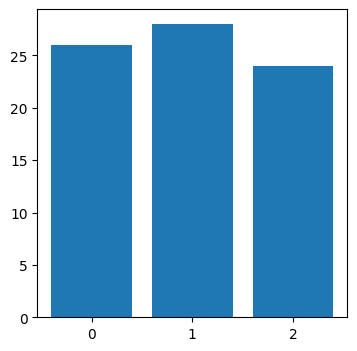

label
1        28
0        26
2        24
Name: count, dtype: int64


In [3]:
# Read and Plotting data
label_data = []
image_data = []
for idx, folder_name in enumerate(os.listdir(RAW_IMAGE_PATH)):
    print(idx," = ",folder_name)
    folder_path = RAW_IMAGE_PATH + folder_name + '/'
    for image in os.listdir(folder_path):
        img_path = folder_path + image
        img = cv.imread(img_path)
        rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        image_data.append(rgb_img)
        label_data.append(idx)

df = pd.DataFrame((label_data),columns=['label'])


def plot(df):
    plt.figure(figsize=(4,4))
    plt.bar(df['label'].value_counts().index,df['label'].value_counts().values)
    plt.xticks(df['label'].value_counts().index)
    plt.show()
    print(df.value_counts())
plot(df)

78
780


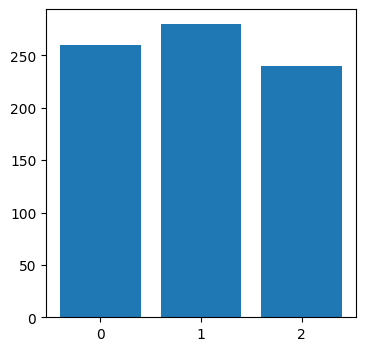

label
1        280
0        260
2        240
Name: count, dtype: int64


In [4]:
# Data Augmentation
# Rotate 10 degree to the left and right
# Stretching the image bigger and smaller
# From the result of stretching above, apply flipping horizontally to the original image and the stretched image

def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, rotation_matrix, (w, h), borderMode=cv.BORDER_REFLECT)
    return rotated

def zoom_image(image, zoom_factor):
    h, w = image.shape[:2]
    center_x, center_y = w // 2, h // 2
    new_w, new_h = int(w / zoom_factor), int(h / zoom_factor)
    x1 = max(center_x - new_w // 2, 0)
    y1 = max(center_y - new_h // 2, 0)
    x2 = x1 + new_w
    y2 = y1 + new_h
    cropped = image[y1:y2, x1:x2]
    zoomed = cv.resize(cropped, (w, h), interpolation=cv.INTER_LINEAR)
    return zoomed

def zoom_out_image(image,zoom_factor):
    h, w = image.shape[:2]
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
    resized = cv.resize(image, (new_w, new_h), interpolation=cv.INTER_LINEAR)
    pad_w = (w - new_w) // 2
    pad_h = (h - new_h) // 2
    zoomed = cv.copyMakeBorder(resized, pad_h, pad_h, pad_w, pad_w, borderType=cv.BORDER_CONSTANT)
    zoomed = zoomed[:h, :w]
    return zoomed

def flip_image_horizontally(image):
    return cv.flip(image, 1)

augmentation_label = label_data.copy()
augmentation_data = image_data.copy()

for label, image in zip(label_data, image_data):

    augmentation_data.append(flip_image_horizontally(image))
    augmentation_label.append(label)

    rotated1 = rotate_image(image, 10)
    augmentation_data.append(rotated1)
    augmentation_label.append(label)
    augmentation_data.append(flip_image_horizontally(rotated1))
    augmentation_label.append(label)
    

    rotated2 = rotate_image(image, -10)
    augmentation_data.append(rotated2)
    augmentation_label.append(label)
    augmentation_data.append(flip_image_horizontally(rotated2))
    augmentation_label.append(label)
    

    zoom = zoom_image(image, 1.2)
    augmentation_data.append(zoom)
    augmentation_label.append(label)
    augmentation_data.append(flip_image_horizontally(zoom))
    augmentation_label.append(label)
    

    unzoom = zoom_out_image(image, 0.8)
    augmentation_data.append(unzoom)
    augmentation_label.append(label)
    augmentation_data.append(flip_image_horizontally(unzoom))
    augmentation_label.append(label)
    # plt.imshow(unzoom)
    # plt.show()

    # plt.imshow(image)
    # plt.show()
    # break



print(len(image_data))
print(len(augmentation_data))

plot(pd.DataFrame((augmentation_label),columns=['label']))


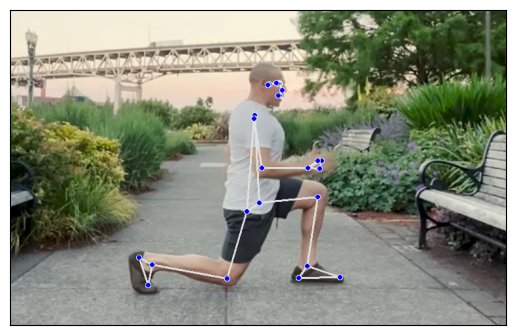

Array of Landmarks length :33


In [5]:
# Mediapipe image test
test_rgb = image_data[0]
test_rgb.flags.writeable = False

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    res = pose.process(test_rgb)
    # print(res.pose_landmarks)

    test_rgb.flags.writeable = True
    mp_drawing.draw_landmarks(test_rgb,res.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    plt.imshow(test_rgb)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print(f"Array of Landmarks length :{len(res.pose_landmarks.landmark)}")


In [6]:
def calculate_angle(a,b,c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    rad = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])

    if rad > np.pi:
        rad -= 2 * np.pi
    elif rad < -np.pi:
        rad += 2 * np.pi

    if rad < 0:
        rad = -rad

    return rad

csv_data = []
with mp_pose.Pose(min_detection_confidence=0.8, min_tracking_confidence=0.8) as pose:
    for idx,(label,img) in enumerate(zip(augmentation_label.copy(), augmentation_data.copy())):
        res = pose.process(img)
        mp_drawing.draw_landmarks(img,res.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        # only taking the leg landmarks (index 23 - 28) - 18 data in total (coordinates for x,y,z)
        try: 
            dict = {}
            landmarks = res.pose_landmarks.landmark
            x_nose = landmarks[0].x
            y_nose= landmarks[0].y
            z_nose= landmarks[0].z
            for i in range(23,29):
                x = landmarks[i].x - x_nose
                y = landmarks[i].y - y_nose
                z = landmarks[i].z - z_nose
                # print("aaaaaa")
                # print("X"+i)
                # print("X"+i+"-"+idx)
                x_col_name = "X"+str(i)
                y_col_name = "Y"+str(i)
                z_col_name = "Z"+str(i)

                dict[x_col_name] = x
                dict[y_col_name] = y
                dict[z_col_name] = z
            dict['rad1'] = calculate_angle([landmarks[23].x,landmarks[23].y],[landmarks[25].x,landmarks[25].y],[landmarks[27].x,landmarks[27].y])
            dict['rad2'] = calculate_angle([landmarks[24].x,landmarks[24].y],[landmarks[26].x,landmarks[26].y],[landmarks[28].x,landmarks[28].y])
            csv_data.append(dict)


        except:
            pass

        # break


In [9]:
data_df = pd.DataFrame(csv_data)
display(data_df)
data_df.to_csv('./Dataset/Processed/result.csv', index=False)

,X23,Y23,Z23,X24,Y24,Z24,X25,Y25,Z25,X26,Y26,Z26,X27,Y27,Z27,X28,Y28,Z28,rad1,rad2
0,-0.050611,0.328414,0.377665,-0.062408,0.346747,0.082647,0.075673,0.321555,0.452509,-0.107053,0.562944,-0.066724,0.055469,0.544697,0.606251,-0.261114,0.545635,0.020681,1.426239,1.662554
1,-0.021964,0.365163,0.165702,-0.051814,0.396390,-0.087872,0.090013,0.330854,0.203207,-0.086385,0.611664,-0.220727,0.075883,0.554291,0.281841,-0.236949,0.544779,-0.093182,1.210328,1.311982
2,0.006377,0.382020,0.258012,-0.037193,0.413299,-0.030466,0.134718,0.341158,0.301251,-0.085413,0.616173,-0.161273,0.112457,0.563660,0.344135,-0.250325,0.558230,0.011013,1.162841,1.466268
3,-0.080506,0.339088,0.219121,-0.061865,0.348102,-0.041165,-0.145484,0.501069,0.237628,0.072883,0.391376,0.027637,-0.286278,0.526417,0.236553,0.041353,0.592056,0.134638,2.130419,1.725693
4,-0.072500,0.362080,0.059596,-0.060695,0.366196,-0.206889,-0.165013,0.543803,0.011529,0.071912,0.349640,-0.115190,-0.312405,0.526008,-0.043720,0.030929,0.579707,0.019686,1.921531,1.270300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.077005,0.290643,0.401055,-0.027849,0.293219,0.419021,0.103859,0.447827,0.340280,-0.010784,0.449313,0.391441,0.128512,0.605372,0.631826,0.029822,0.612683,0.689459,3.127603,3.006877
776,0.050719,0.331979,0.586467,-0.061178,0.340340,0.493383,0.091134,0.529096,0.497658,-0.043570,0.531026,0.390605,0.088427,0.726299,0.761579,-0.037800,0.730604,0.682706,2.925638,3.078412
777,0.062818,0.348651,0.416080,-0.056849,0.351351,0.504435,0.053087,0.548219,0.312026,-0.106411,0.550029,0.412656,0.049922,0.749308,0.488996,-0.077783,0.746390,0.674260,3.108613,2.752351
778,0.033563,0.243035,0.449378,-0.043075,0.246787,0.425215,0.050345,0.378119,0.440326,-0.041826,0.387044,0.401235,0.045107,0.509588,0.582461,-0.034533,0.519342,0.571111,2.978174,3.095428
